This notebook compares annotations using different GLLMs with codebooks based prompts of Boukes 2024, Jaidka 2022 and Naab 2025 on their respective datasets

In [2]:
import requests
import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time

import typing

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import pandas as pd

import config
import src
import tqdm
import json
import numpy as np
import logging

#import cltrier_lib as lib
import pyreadstat
import yaml
pd.set_option('display.max_colwidth', 100) 
#set up helper variables and functions:
CFG = config.Config()


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "c:\Users\sstolwi\Github\llmdiv\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_loop.start()
  File "c:\Users\sstolwi\Git

In [172]:
#load data:

# Jaida2024 data
jaidka = pd.read_parquet('data/jaidka2022/TwitterDeliberativePolitics2.parquet')
# Boukes
boukes = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')
boukesT = pd.read_csv('data/publicsphere/full_data.csv') # this includes the comments
#the Boukes2024 data is a subset of this, select YT part of Boukes in line with Boukes2024:
boukesTYT = boukesT[boukesT['Platform'] == 1]
#MH_clemm 2024
MHclemm = pd.read_parquet('data/MH_BClemm_data/Ideo_Val_GPT_USA_L33_70b.parquet')


list the variables we want to use:
**rationality** - prompt: 'rationality_simple2', 'rationality_jaidka',        
  manual coding: "Justification" (Jaidka), RATIONALITY_DUMMY
**incivility** - prompt: 'incivility_simple2', 'incivility_jaidka',  civility_jaidka         
  manual coding: INCIVILITY_DUMMY, Incivility_tot ('Uncivil_abuse', 'Empathy_Respect'), Uncivil_abuse, "Empathy_Respect" (jaidka)
**interactivity** - prompt: 'interactivity_acknowledgement_simple', interactivity_acknowledgement_jaidka       
  manual coding: INTERACTIVITY_DUMMY, Reciprocity (Jaidka)
**diversity/ideology** - prompt: 'political_ideology_US', 'political_ideology' (german)  -> no ideology in Jaidka
  manual coding: LIBERAL_DUMMY, CONSERVATIVE_DUMMY
**political_dum** - prompt: 'political_post', political_post_jaidka 
  manual coding: HAS_OPINION_DUMMY

Update and clarify variable names

In [186]:
boukes.columns.to_list()

['StartDate',
 'RecordedDate',
 'IPAddress',
 'Finished',
 'Coder',
 'ID',
 'Mark_ID',
 'Genre',
 'topiccode',
 'Platform',
 'Anonymity',
 'Anonymity_9_TEXT',
 'codable',
 'Interaction',
 'Acknowledgement',
 'TopicRelevance',
 'Reasoning',
 'BackgroundInfo',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Opinion',
 'disagreement',
 'Ideologicaldirection',
 'Name_calling',
 'Vulgarity',
 'Attack_reputation',
 'Question_Intelligenc',
 'All_caps_function',
 'Sarcasm_to_criticize',
 'Individual_right',
 'discrimination',
 'Invoke_violence',
 'Tone',
 'INTERACTIVITY_DUMMY',
 'RATIONALITY_DUMMY',
 'HAS_OPINION_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'LIBERAL_DUMMY',
 'CONSERVATIVE_DUMMY',
 'NAMECALLING_DUMMY',
 'VULGAR_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'INCIVILITY_ORDINAL',
 'INCIVILITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'filter_$',
 'IMPOLITENESS_DUMMY',
 'showName',
 'genre',
 'Time_comment',
 'likeCount_comment',
 'entities',
 'place',
 'retweet_count',
 'platform',
 'retweeted',
 '

In [26]:
#define functions:
def get_macro_f1_score(df, model_col, groundtruth_col):
    """
    Calculate the macro F1 score for a given model column against the ground truth.
    """
    y_true = df[groundtruth_col]
    y_pred = df[model_col]
    
    # Ensure both series are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true labels and predicted labels must be the same.")
    
    # Calculate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Return macro F1 score
    return report['macro avg']['f1-score']

In [33]:
boukes.columns.to_list()

['StartDate',
 'RecordedDate',
 'IPAddress',
 'Finished',
 'Coder',
 'ID',
 'Mark_ID',
 'Genre',
 'topiccode',
 'Platform',
 'Anonymity',
 'Anonymity_9_TEXT',
 'codable',
 'Interaction',
 'Acknowledgement',
 'TopicRelevance',
 'Reasoning',
 'BackgroundInfo',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Opinion',
 'disagreement',
 'Ideologicaldirection',
 'Name_calling',
 'Vulgarity',
 'Attack_reputation',
 'Question_Intelligenc',
 'All_caps_function',
 'Sarcasm_to_criticize',
 'Individual_right',
 'discrimination',
 'Invoke_violence',
 'Tone',
 'INTERACTIVITY_DUMMY',
 'RATIONALITY_DUMMY',
 'HAS_OPINION_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'LIBERAL_DUMMY',
 'CONSERVATIVE_DUMMY',
 'NAMECALLING_DUMMY',
 'VULGAR_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'INCIVILITY_ORDINAL',
 'INCIVILITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'filter_$',
 'IMPOLITENESS_DUMMY',
 'showName',
 'genre',
 'Time_comment',
 'likeCount_comment',
 'entities',
 'place',
 'retweet_count',
 'platform',
 'retweeted',
 '

In [ ]:
#feasability check:
#do annotations of Llama3.3:70b correlate with gpt4o?
boukes.loc[:, ['rationality_simple2_L33_70b_dum', 'rationality_jaidka_L33_70b_dum', 'rationality_simple2_small_dum', 'rationality_simple2_gpt4o_dum', 'rationality_simple_dum', 'RATIONALITY_DUMMY']] \
    .corr(method='pearson').round(2)

,rationality_simple2_L33_70b_dum,rationality_jaidka_L33_70b_dum,rationality_simple2_small_dum,rationality_simple2_gpt4o_dum,rationality_simple_dum,RATIONALITY_DUMMY
rationality_simple2_L33_70b_dum,1.00,0.29,0.46,0.39,0.71,0.41
rationality_jaidka_L33_70b_dum,0.29,1.00,0.12,0.11,0.31,0.30
rationality_simple2_small_dum,0.46,0.12,1.00,0.54,0.42,0.25
rationality_simple2_gpt4o_dum,0.39,0.11,0.54,1.00,0.32,0.25
rationality_simple_dum,0.71,0.31,0.42,0.32,1.00,0.33
RATIONALITY_DUMMY,0.41,0.30,0.25,0.25,0.33,1.00


improved performance of L33_70b compared to L31_70b (default), and the two models also show the highest overlap

In [ ]:
#and in crosstabulations:
pd.crosstab(boukes['RATIONALITY_DUMMY'], [boukes['rationality_simple2_L33_70b_dum'], boukes['rationality_simple2_small_dum']], margins=True, margins_name='Total')

rationality_simple2_L33_70b_dum     0        1      Total
rationality_simple2_small_dum       0   1    0    1      
RATIONALITY_DUMMY                                        
0                                2930  14  181   40  3165
1                                 394   1  202  100   697
Total                            3324  15  383  140  3862

#L33_70b and small share 100+2930=3030 correct classifications (78%) and share 40+394=434 errors (11%) and differ on 14+1+181+202=398 errors (10%)-> they differ on 48% of errors
#L33_70b makes 2930+14+202+100=3246 correct classifications
and 394+1+181+40=616 errors = 16%
#small makes 2930+181+1+100=3212 correct classifications
and 394+14+202+40=650 errors = 17%
#we would thus expect 0.17*0.16 = only 3% overlap between errors if the models were random -> they thus do a lot better than that


In [ ]:
#and in crosstabulations:
pd.crosstab(boukes['RATIONALITY_DUMMY'], [boukes['rationality_simple2_L33_70b_dum'], boukes['rationality_simple2_gpt4o_dum']], margins=True, margins_name='Total')

rationality_simple2_L33_70b_dum     0    1     Total
rationality_simple2_gpt4o_dum       0    0   1      
RATIONALITY_DUMMY                                   
0                                2944  205  16  3165
1                                 395  230  72   697
Total                            3339  435  88  3862

#L33_70b and gpt4o share only 16 errors (0%) and differ on 205+230=435 errors (11%) -> they differ on 96% of errors
#L33_70b and gpt4o correctly classify 2944+72=3016 (78%)
#so L33_70b shares the same share of correct classifications in combination with small and gpt4o, but errors overlap much more with small than with gpt4o, which makes sense, overlap between errors of L33_70b and gpt4o is equal to chance.
#this indicates that these two models don't agree on which manual coding are actually coding errors -> together they only mark 16 comments as potentially wrong coded even though they haven't seen our annotations in their training data, so should be independently judging the rationality of the comments.

In [ ]:
#do annotations of Llama3.3:70b correlate with gpt4o?
boukes.loc[:, ['incivility_simple2_L33_70b_dum', 'incivility_jaidka_L33_70b_dum', 'incivility_simple2_small_dum', 'incivility_simple2_gpt4o_dum', 'INCIVILITY_DUMMY']] \
    .corr(method='pearson').round(2)

,incivility_simple2_L33_70b_dum,incivility_jaidka_L33_70b_dum,incivility_simple2_small_dum,incivility_simple2_gpt4o_dum,INCIVILITY_DUMMY
incivility_simple2_L33_70b_dum,1.00,0.76,0.49,0.58,0.54
incivility_jaidka_L33_70b_dum,0.76,1.00,0.53,0.63,0.51
incivility_simple2_small_dum,0.49,0.53,1.00,0.68,0.48
incivility_simple2_gpt4o_dum,0.58,0.63,0.68,1.00,0.55
INCIVILITY_DUMMY,0.54,0.51,0.48,0.55,1.00


In [ ]:
#do annotations of Llama3.3:70b correlate with gpt4o?
boukes.loc[:, ['political_post_L33_70b_dum', 'political_post_jaidka_L33_70b_dum', 'TopicRelevance']] \
    .corr(method='pearson').round(2)

,political_post_L33_70b_dum,political_post_jaidka_L33_70b_dum,TopicRelevance
political_post_L33_70b_dum,1.00,0.49,0.58
political_post_jaidka_L33_70b_dum,0.49,1.00,0.38
TopicRelevance,0.58,0.38,1.00


In [ ]:
#what is the infuence of temperature on the results of intraprompt annotation reliability?

#Note the logic of our comparisons:
#we compare the results of the same prompt with different models, and different seeds, to see if the model and/or seed influences the results.
#we use similar options per model, but the options are not the same for all models, they differ in temperature and seed (since the same seed might mean something different for different models).
#but since we compare intraprompt annotation reliability for the same prompt with different seeds, the difference in temperature is not a problem, the annotation might differ per output of the model for that seed/temperature, but the difference with another seed should be minimal.
#anyway we can test the origins of intraprompt reliability by comparing the result of the same prompt with the same seed and low temperature, different seed and low temperature and same seed and zero temperature
#if it turns out that temperature does have a larger influence, but still the influence of different models or prompts is larger, we can still conclude that the model and prompt are more important than the temperature.
#stronger still a higher temperature intraprompt benchmark is harder to beat especially for the simpa-prompts
#for the between model comparisons temperature per model should not be a problem, since it will only vary the result of the model, not the comparison between models, only downside of low temperature is potential slightly lower reproducibility of the exact results and potetially slightly lower performance due to less creativity, but Barry ea 2025 does not seem to suggest this is the case for such low temperatures.

In [11]:
#calculate correlations between the different models for all columns ending with _dum and containing 'incivility' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'gpt4o' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col or 'Q72b' in col]
incivility_cols = [col for col in incivility_cols if 'zero' in col]  
incivility_corr = boukes[incivility_cols].corr(method='pearson').round(2)
print("Incivility correlations:")
incivility_corr

Incivility correlations:


,incivility_simple2_gpt4o_zero_dum,incivility_simple2_gpt4o_system_zero_dum,incivility_simple2_Q72b_zero_dum,incivility_jaidka_Q25_72b_zero_dum,incivility_para1_Q25_72b_zero_dum,incivility_para2_Q25_72b_zero_dum,incivility_simpa1_Q25_72b_zero_dum,incivility_simple2_Q72b_seed2_zero_dum,incivility_simple2_L33_70b_zero_dum,incivility_simple2_L33_70b_zero_seed2_dum,incivility_simple2_L31_8b_zero_dum,incivility_simple2_L31_8b_zero_seed2_dum,incivility_jaidka_gpt4o_system_zero_dum,incivility_para1_gpt4o_system_zero_dum,incivility_para2_gpt4o_system_zero_dum,incivility_simpa1_gpt4o_system_zero_dum
incivility_simple2_gpt4o_zero_dum,1.00,0.88,0.56,0.60,0.55,0.51,0.54,0.56,0.55,0.55,0.64,0.64,0.73,0.79,0.82,0.81
incivility_simple2_gpt4o_system_zero_dum,0.88,1.00,0.55,0.59,0.54,0.50,0.53,0.55,0.53,0.53,0.67,0.67,0.76,0.85,0.84,0.84
incivility_simple2_Q72b_zero_dum,0.56,0.55,1.00,0.87,0.96,0.92,0.96,1.00,0.85,0.85,0.55,0.54,0.55,0.59,0.64,0.59
incivility_jaidka_Q25_72b_zero_dum,0.60,0.59,0.87,1.00,0.86,0.84,0.86,0.87,0.80,0.80,0.57,0.57,0.59,0.62,0.67,0.62
incivility_para1_Q25_72b_zero_dum,0.55,0.54,0.96,0.86,1.00,0.92,0.94,0.96,0.84,0.84,0.54,0.54,0.54,0.58,0.63,0.59
incivility_para2_Q25_72b_zero_dum,0.51,0.50,0.92,0.84,0.92,1.00,0.93,0.92,0.83,0.83,0.51,0.50,0.51,0.54,0.59,0.55
incivility_simpa1_Q25_72b_zero_dum,0.54,0.53,0.96,0.86,0.94,0.93,1.00,0.96,0.85,0.85,0.54,0.53,0.53,0.57,0.62,0.58
incivility_simple2_Q72b_seed2_zero_dum,0.56,0.55,1.00,0.87,0.96,0.92,0.96,1.00,0.85,0.85,0.55,0.54,0.55,0.59,0.64,0.59
incivility_simple2_L33_70b_zero_dum,0.55,0.53,0.85,0.80,0.84,0.83,0.85,0.85,1.00,1.00,0.54,0.54,0.53,0.58,0.63,0.58
incivility_simple2_L33_70b_zero_seed2_dum,0.55,0.53,0.85,0.80,0.84,0.83,0.85,0.85,1.00,1.00,0.54,0.54,0.53,0.58,0.63,0.58


In [27]:
#calculate correlations between the different models for all columns ending with _dum and containing 'rationality' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'gpt4o' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col or 'Q72b' in col]
incivility_cols = [col for col in incivility_cols if 'zero' in col]  
incivility_cols = [col for col in incivility_cols if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model
#add groundtruth columns:
incivility_cols += ['INCIVILITY_DUMMY']
incivility_corr = boukes[incivility_cols].corr(method='pearson').round(2)

incivility_corr

,incivility_simple2_gpt4o_system_zero_dum,incivility_simple2_Q72b_zero_dum,incivility_simple2_L33_70b_zero_dum,incivility_simple2_L31_8b_zero_dum,INCIVILITY_DUMMY
incivility_simple2_gpt4o_system_zero_dum,1.00,0.55,0.53,0.67,0.51
incivility_simple2_Q72b_zero_dum,0.55,1.00,0.85,0.55,0.47
incivility_simple2_L33_70b_zero_dum,0.53,0.85,1.00,0.54,0.48
incivility_simple2_L31_8b_zero_dum,0.67,0.55,0.54,1.00,0.45
INCIVILITY_DUMMY,0.51,0.47,0.48,0.45,1.00


In [ ]:
#model has quite a large effect on the results, comparable to the error rate of the groundtruth.

In [29]:
#calculate correlations between the different models for all columns ending with _dum and containing 'rationality' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'L33_70b' in col]
#add groundtruth columns:
incivility_cols += ['INCIVILITY_DUMMY']
incivility_corr = boukes[incivility_cols].corr(method='pearson').round(2)

incivility_corr

,incivility_simple2_L33_70b_low_dum,incivility_jaidka_L33_70b_low_dum,incivility_simple2_L33_70b_seed2_low_dum,incivility_para1_L33_70b_low_dum,incivility_para2_L33_70b_low_dum,incivility_simpa1_L33_70b_low_dum,incivility_simple2_L33_70b_seed2_run2_low_dum,incivility_simple2_L33_70b_zero_dum,incivility_simple2_L33_70b_zero_seed2_dum,INCIVILITY_DUMMY
incivility_simple2_L33_70b_low_dum,1.00,0.76,0.85,0.82,0.79,0.81,0.85,0.85,0.85,0.54
incivility_jaidka_L33_70b_low_dum,0.76,1.00,0.67,0.68,0.68,0.69,0.67,0.67,0.67,0.51
incivility_simple2_L33_70b_seed2_low_dum,0.85,0.67,1.00,0.96,0.94,0.95,0.99,1.00,1.00,0.48
incivility_para1_L33_70b_low_dum,0.82,0.68,0.96,1.00,0.94,0.95,0.96,0.96,0.96,0.48
incivility_para2_L33_70b_low_dum,0.79,0.68,0.94,0.94,1.00,0.92,0.94,0.94,0.94,0.48
incivility_simpa1_L33_70b_low_dum,0.81,0.69,0.95,0.95,0.92,1.00,0.95,0.95,0.95,0.48
incivility_simple2_L33_70b_seed2_run2_low_dum,0.85,0.67,0.99,0.96,0.94,0.95,1.00,0.99,0.99,0.48
incivility_simple2_L33_70b_zero_dum,0.85,0.67,1.00,0.96,0.94,0.95,0.99,1.00,1.00,0.48
incivility_simple2_L33_70b_zero_seed2_dum,0.85,0.67,1.00,0.96,0.94,0.95,0.99,1.00,1.00,0.48
INCIVILITY_DUMMY,0.54,0.51,0.48,0.48,0.48,0.48,0.48,0.48,0.48,1.00


In [ ]:
#it appears rewording, reformatting, changing seed and temperature has about equal influence, changing to Jaidka prompt has a larger influence, the zero temperature prompt does have a better correlation with a different seed than the low temperature prompt, 
#suprisingly low correlation between incivility_simple2_L33_70b_seed2_low_dum/incivility_simple2_L33_70b_seed2_run2_low_dum and incivility_simple2_L33_70b_low_dum -> temperature can sometimes have a larger effect than expected, but correlation is still much higher than with the groundtruth

In [30]:
#calculate correlations between the different models for all columns ending with _dum and containing 'rationality' in boukes, start with the gpt4o model and zero temperature::
incivility_cols = [col for col in boukes.columns if 'incivility' in col]
incivility_cols = [col for col in incivility_cols if col.endswith('_dum')]
incivility_cols = [col for col in incivility_cols if 'gpt4o' in col]
#add groundtruth columns:
incivility_cols += ['INCIVILITY_DUMMY']
incivility_corr = boukes[incivility_cols].corr(method='pearson').round(2)

incivility_corr

,incivility_simple2_gpt4o_zero_dum,incivility_simple2_gpt4o_system_zero_dum,incivility_jaidka_gpt4o_system_zero_dum,incivility_para1_gpt4o_system_zero_dum,incivility_para2_gpt4o_system_zero_dum,incivility_simpa1_gpt4o_system_zero_dum,INCIVILITY_DUMMY
incivility_simple2_gpt4o_zero_dum,1.00,0.88,0.73,0.79,0.82,0.81,0.55
incivility_simple2_gpt4o_system_zero_dum,0.88,1.00,0.76,0.85,0.84,0.84,0.51
incivility_jaidka_gpt4o_system_zero_dum,0.73,0.76,1.00,0.81,0.78,0.79,0.45
incivility_para1_gpt4o_system_zero_dum,0.79,0.85,0.81,1.00,0.90,0.91,0.47
incivility_para2_gpt4o_system_zero_dum,0.82,0.84,0.78,0.90,1.00,0.89,0.50
incivility_simpa1_gpt4o_system_zero_dum,0.81,0.84,0.79,0.91,0.89,1.00,0.49
INCIVILITY_DUMMY,0.55,0.51,0.45,0.47,0.50,0.49,1.00


In [ ]:
#calculate correlations between the different models for all columns ending with _dum and containing 'rationality' in boukes, start with the gpt4o model and zero temperature::
rationality_cols = [col for col in boukes.columns if 'rationality' in col]
rationality_cols = [col for col in rationality_cols if col.endswith('_dum')]
rationality_cols = [col for col in rationality_cols if 'L33_70b' in col]
#add groundtruth columns:
rationality_cols += ['RATIONALITY_DUMMY']
rationality_corr = boukes[rationality_cols].corr(method='pearson').round(2)

rationality_corr

,rationality_simple2_L33_70b_low_dum,rationality_jaidka_L33_70b_low_dum,rationality_simple2_para1_L33_70b_low_dum,rationality_simple2_L33_70b_seed2_low_dum,rationality_simple2_para2_L33_70b_low_dum,rationality_simple2_simpa1_L33_70b_low_dum,rationality_simple2_L33_70b_seed2_run2_low_dum,rationality_simple2_L33_70b_zero_dum,rationality_simple2_L33_70b_zero_seed2_dum,RATIONALITY_DUMMY
rationality_simple2_L33_70b_low_dum,1.00,0.29,0.90,0.97,0.92,0.88,0.95,0.97,0.97,0.41
rationality_jaidka_L33_70b_low_dum,0.29,1.00,0.28,0.28,0.28,0.27,0.29,0.28,0.28,0.30
rationality_simple2_para1_L33_70b_low_dum,0.90,0.28,1.00,0.92,0.96,0.91,0.91,0.92,0.92,0.39
rationality_simple2_L33_70b_seed2_low_dum,0.97,0.28,0.92,1.00,0.94,0.91,0.97,1.00,1.00,0.40
rationality_simple2_para2_L33_70b_low_dum,0.92,0.28,0.96,0.94,1.00,0.91,0.93,0.94,0.94,0.40
rationality_simple2_simpa1_L33_70b_low_dum,0.88,0.27,0.91,0.91,0.91,1.00,0.89,0.91,0.91,0.38
rationality_simple2_L33_70b_seed2_run2_low_dum,0.95,0.29,0.91,0.97,0.93,0.89,1.00,0.97,0.97,0.40
rationality_simple2_L33_70b_zero_dum,0.97,0.28,0.92,1.00,0.94,0.91,0.97,1.00,1.00,0.40
rationality_simple2_L33_70b_zero_seed2_dum,0.97,0.28,0.92,1.00,0.94,0.91,0.97,1.00,1.00,0.40
RATIONALITY_DUMMY,0.41,0.30,0.39,0.40,0.40,0.38,0.40,0.40,0.40,1.00


In [ ]:
#it appears rewording, reformatting, changing seed and temperature has about equal influence, changing to Jaidka prompt has a larger influence, the zero temperature prompt does have a better correlation with a different seed than the low temperature prompt, but effects are small



In [ ]:
#get performance metrics for all models and prompts in boukes in terms of macro F1 score:

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col or 'Q72b' in col)]
# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    # Skip columns that are not relevant for the analysis
    if 'seed2' in model_col or 'run2' in model_col or 'para' in model_col or 'simpa' in model_col or 'gpt4o_zero' in model_col or 'jaidka' in model_col:
        continue
    if 'incivility' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'INCIVILITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['INCIVILITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'rationality' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'RATIONALITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['RATIONALITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'interactivity' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'INTERACTIVITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['INTERACTIVITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_lib' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'LIBERAL_DUMMY')
            accuracy = (boukes[model_col] == boukes['LIBERAL_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy        
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_con' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'CONSERVATIVE_DUMMY')
            accuracy = (boukes[model_col] == boukes['CONSERVATIVE_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy        
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'political_post' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'TopicRelevance')
            accuracy = (boukes[model_col] == boukes['TopicRelevance']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy        
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")

# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Model': list(macro_f1_scores.keys()),
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()]
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by='Macro F1 Score', ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for Boukes Data:")
print(scores_df)

Macro F1 Scores and Accuracy for Boukes Data:
                                                         Model  \
9                   political_conservative_US_gpt4o_system_dum   
10                       political_liberal_US_gpt4o_system_dum   
1                            incivility_simple2_gpt4T_zero_dum   
14                  political_conservative_US_gpt4T_system_dum   
18                              political_post_L33_70b_low_dum   
13                    incivility_simple2_gpt4T_system_zero_dum   
15                       political_liberal_US_gpt4T_system_dum   
19                   political_ideology_US_L33_70b_low_con_dum   
36       interactivity_acknowledgement_simple_L33_70b_zero_dum   
20                   political_ideology_US_L33_70b_low_lib_dum   
17                          incivility_simple2_L33_70b_low_dum   
23                  political_ideology_US_L33_70b_zero_con_dum   
4                          political_conservative_US_gpt4T_dum   
44        interactivity_acknow

In [ ]:
#in contrast to findings in other paper (where we tested L31:70b, gpt4o,gpt4T), here we find that L33:70b and Qwen2.5:70b are able to annotate interactivity with high quality.

In [ ]:
#need to remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

In [ ]:
#let's look at RQs

###Stage 1: benchmark performance on Boukes2024 data:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?
#RQ3: What is the influence of a different codebook (i.e. Jaidka) on model performance on Boukes2024, relative to the influence of prompt wording, seed and temperature?
#Appendix1: Does this influence of model, promptwording and codebook depend on the dataset at hand, compared to Jaidka2024 and MH_clemm2024 data?

###Stage 2: Do the models measure the same thing? 
#RQ4: What is the overlap in the concepts measured by the different models on Boukes2024 data, with Boukes prompts?
#RQ5: What is the overlap in the concepts measured by the different prompts on Boukes2024 data?
#Appendix2: Does this overlap replicate in Jaidka2024 and MH_clemm2024 data?

###Stage 3: Do the models measure the same thing as humans?
#RQ6: Which comments are annotated correctly per model/prompt, and which are not? (Venn diagram?)

###Stage 4:
#RQ7: What is the influence of model, prompt wording and codebook on the downstream results in Boukes2024?


In [32]:
#RQ1: How well do the different models perform on the Boukes2024 data, with Boukes prompts?

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
name = {}
model = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    if 'incivility' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'INCIVILITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['INCIVILITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Incivility'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'rationality' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'RATIONALITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['RATIONALITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Rationality'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'interactivity' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'INTERACTIVITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['INTERACTIVITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Interactivity'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_lib' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'LIBERAL_DUMMY')
            accuracy = (boukes[model_col] == boukes['LIBERAL_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy     
            name[model_col] = 'Liberal'   
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_con' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'CONSERVATIVE_DUMMY')
            accuracy = (boukes[model_col] == boukes['CONSERVATIVE_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Conservative'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'political_post' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'TopicRelevance')
            accuracy = (boukes[model_col] == boukes['TopicRelevance']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Political Post'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'gpt4o' in model_col:
            model[model_col] = 'gpt4o'
    if 'gpt4T' in model_col:
            model[model_col] = 'gpt4T'
    if 'L33_70b' in model_col:
            model[model_col] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
            model[model_col] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
            model[model_col] = 'Qwen2.5:72b'
        


# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Label': list(macro_f1_scores.keys()),
    'Concept': [name[model_col] for model_col in macro_f1_scores.keys()],
    'Model': [model[model_col] for model_col in macro_f1_scores.keys()],
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()]
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by=['Concept', 'Model'], ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for Boukes Data:")
print(scores_df)

Macro F1 Scores and Accuracy for Boukes Data:
                                                         Label  \
1                    rationality_simple2_gpt4o_system_zero_dum   
3                    rationality_simple2_gpt4T_system_zero_dum   
15                        rationality_simple2_Q25_72b_zero_dum   
19                        rationality_simple2_L33_70b_zero_dum   
23                         rationality_simple2_L31_8b_zero_dum   
14                             political_post_Q25_72b_zero_dum   
18                             political_post_L33_70b_zero_dum   
22                              political_post_L31_8b_zero_dum   
25             political_ideology_US_gpt4o_system_zero_lib_dum   
27             political_ideology_US_gpt4T_system_zero_lib_dum   
7                   political_ideology_US_Q25_72b_zero_lib_dum   
9                   political_ideology_US_L33_70b_zero_lib_dum   
11                   political_ideology_US_L31_8b_zero_lib_dum   
2   interactivity_acknowledgem

In [ ]:
#interactivity beats BERT F1 (0.75), rationality comes close to BERT F1 (0.72)
#accuracy is 0.70 or up, F1 score is 0.57 or up
#overal decent performance of models, more variance for interactivity (F1: 0.60-0.77), 
#moderate variance between models for conservative (F1: 0.68-0.80) between models,  
#low variance for political post (F1: 0.72-0.73), liberal (F1: 0.70-0.79) and incivility (F1: 0.73-0.78, except for L31: 0.68) and rationality (F1: 0.57-0.63 except for L33: 0.69)

In [ ]:
#RQ2: What is the influence of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature?

#TODO: update this table and visualize the effect of prompt wording on the performance of the models on Boukes2024 data, relative to model noise in terms of seed and temperature

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col) and 'political_conservative' not in col and 'political_liberal' not in col]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4o_zero' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

# Initialize a dictionary to store macro F1 scores
macro_f1_scores = {}
accuracy_scores = {}
name = {}
model = {}
temperature = {}
seed = {}
run = {}
prompt_variant = {}
# Calculate macro F1 scores for each model column
for model_col in model_columns:
    if 'incivility' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'INCIVILITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['INCIVILITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Incivility'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'rationality' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'RATIONALITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['RATIONALITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Rationality'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'interactivity' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'INTERACTIVITY_DUMMY')
            accuracy = (boukes[model_col] == boukes['INTERACTIVITY_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy
            name[model_col] = 'Interactivity'
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_lib' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'LIBERAL_DUMMY')
            accuracy = (boukes[model_col] == boukes['LIBERAL_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy     
            name[model_col] = 'Liberal'   
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if '_con' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'CONSERVATIVE_DUMMY')
            accuracy = (boukes[model_col] == boukes['CONSERVATIVE_DUMMY']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Conservative'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'political_post' in model_col:
        try:
            macro_f1 = get_macro_f1_score(boukes, model_col, 'TopicRelevance')
            accuracy = (boukes[model_col] == boukes['TopicRelevance']).mean()
            macro_f1_scores[model_col] = macro_f1
            accuracy_scores[model_col] = accuracy  
            name[model_col] = 'Political Post'      
        except ValueError as e:
            logging.error(f"Error calculating F1 score for {model_col}: {e}")
    if 'gpt4o' in model_col:
            model[model_col] = 'gpt4o'
    if 'gpt4T' in model_col:
            model[model_col] = 'gpt4T'
    if 'L33_70b' in model_col:
            model[model_col] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
            model[model_col] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
            model[model_col] = 'Qwen2.5:72b'
    if 'low' in model_col:
            temperature[model_col] = 'Low: 0.1'
    if 'zero' in model_col:
            temperature[model_col] = 'Zero: 0.0'
    if 'seed2' in model_col:
            seed[model_col] = 'Seed 2'
    if 'seed2' not in model_col:
            seed[model_col] = 'Seed 1'
    if 'run2' in model_col:
            run[model_col] = 'Run 2'
    if 'run2' not in model_col:
            run[model_col] = 'Run 1'       
    if 'seed2' not in model_col:
            seed[model_col] = 'Seed 1'
    if 'para1' in model_col:
        prompt_variant[model_col] = 'Para1'
    if 'para2' in model_col:
        prompt_variant[model_col] = 'Para2'
    if 'simpa1' in model_col:
        prompt_variant[model_col] = 'Simpa1'
    if 'jaidka' in model_col:
        prompt_variant[model_col] = 'Jaidka'
    if 'para1' not in model_col and 'para2' not in model_col and 'simpa1' not in model_col and 'jaidka' not in model_col:
        prompt_variant[model_col] = 'Boukes'

# Convert the macro F1 scores and accuracy scores to a DataFrame for better visualization
scores_df = pd.DataFrame({
    'Label': list(macro_f1_scores.keys()),
    'Concept': [name[model_col] for model_col in macro_f1_scores.keys()],
    'Model': [model[model_col] for model_col in macro_f1_scores.keys()],
    'Temperature': [temperature[model_col] for model_col in macro_f1_scores.keys()],
    'Prompt Variant': [prompt_variant[model_col] for model_col in macro_f1_scores.keys()],
    'Seed': [seed[model_col] for model_col in macro_f1_scores.keys()],
    'Run': [run[model_col] for model_col in macro_f1_scores.keys()],
    'Macro F1 Score': list(macro_f1_scores.values()),
    'Accuracy': [accuracy_scores[model] for model in macro_f1_scores.keys()]
})

# Sort the DataFrame by Macro F1 Score in descending order
scores_df = scores_df.sort_values(by=['Concept', 'Model', 'Temperature', 'Seed', 'Run', 'Prompt Variant'], ascending=False)

# Round the scores to 2 decimal places
scores_df['Macro F1 Score'] = scores_df['Macro F1 Score'].round(2)
scores_df['Accuracy'] = scores_df['Accuracy'].round(2)

# Display the scores
print("Macro F1 Scores and Accuracy for Boukes Data:")
print(scores_df)

Macro F1 Scores and Accuracy for Boukes Data:
                                               Label       Concept  \
142         rationality_jaidka_gpt4o_system_zero_dum   Rationality   
1          rationality_simple2_gpt4o_system_zero_dum   Rationality   
3          rationality_simple2_gpt4T_system_zero_dum   Rationality   
117       rationality_simple2_Q25_72b_seed2_zero_dum   Rationality   
113      rationality_simple2_simpa1_Q25_72b_zero_dum   Rationality   
..                                               ...           ...   
46         political_ideology_US_L31_8b_zero_con_dum  Conservative   
30    political_ideology_US_L31_8b_seed2_low_con_dum  Conservative   
28   political_ideology_US_simpa1_L31_8b_low_con_dum  Conservative   
26    political_ideology_US_para2_L31_8b_low_con_dum  Conservative   
24    political_ideology_US_para1_L31_8b_low_con_dum  Conservative   

           Model Temperature Prompt Variant    Seed    Run  Macro F1 Score  \
142        gpt4o   Zero: 0.0       

In [182]:
# 1. Map model_col to readable labels as a dictionary
def get_labels(model_col):
    labels = {
        'concept': '',
        'model': '',
        'temperature': '',
        'seed': '',
        'run': '',
        'prompt_variant': ''
    }
    if 'rationality' in model_col:
        labels['concept'] = 'Rationality'
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        labels['concept'] = 'Interactivity'
    if 'political_post' in model_col:
        labels['concept'] = 'Political Post'
    if '_con' in model_col:
        labels['concept'] = 'Conservative'
    if '_lib' in model_col:
        labels['concept'] = 'Liberal'
    if 'incivility' in model_col:
        labels['concept'] = 'Incivility'
    if 'gpt4o' in model_col:
        labels['model'] = 'GPT4o'
    if 'gpt4T' in model_col:
        labels['model'] = 'GPT4T'
    if 'L33_70b' in model_col:
        labels['model'] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
        labels['model'] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
        labels['model'] = 'Qwen2.5:72b'
    if 'low' in model_col:
        labels['temperature'] = 'Low: 0.1'
    if 'zero' in model_col:
        labels['temperature'] = 'Zero: 0.0'
    if 'seed2' in model_col:
        labels['seed'] = 'Seed 2'
    if not 'seed2' in model_col:
        labels['seed'] = 'Seed 1'
    if 'run2' in model_col:
        labels['run'] = 'Run 2'
    if not 'run2' in model_col:
        labels['run'] = 'Run 1'
    if 'para1' in model_col:
        labels['prompt_variant'] = 'Para1'
    if 'para2' in model_col:
        labels['prompt_variant'] = 'Para2'
    if 'simpa1' in model_col:
        labels['prompt_variant'] = 'Simpa1'
    if 'jaidka' in model_col:
        labels['prompt_variant'] = 'Jaidka'
    if not ('para1' in model_col or 'para2' in model_col or 'simpa1' in model_col or 'jaidka' in model_col):
        labels['prompt_variant'] = 'Boukes'
    return labels

#'political_conservative_US_L31_8b_dum_low',
# 'political_liberal_US_L31_8b_dum_low',

# 2. Build a mapping from column names to their labels (as dicts)
# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if '_dum' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col ]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column

col_labels = {}
for col in model_columns:
    col_labels[col] = get_labels(col)
#    print(f"{col}: {col_labels[col]}")

def get_col_by_labels(concept='', model='', temperature='', seed='', run='', prompt_variant=''):
    matches = []
    for col, labels in col_labels.items():
        if (not concept or labels['concept'] == concept) and \
           (not model or labels['model'] == model) and \
           (not temperature or labels['temperature'] == temperature) and \
           (not seed or labels['seed'] == seed) and \
           (not run or labels['run'] == run) and \
           (not prompt_variant or labels['prompt_variant'] == prompt_variant):
            matches.append(col)
    return matches[0] if matches else None

## 4. Define metrics and their column selection logic
metrics_zero = [
    # concept, metric_name, col1_kwargs, col2_kwargs
    ('inter_jaidka', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Jaidka'}),
    ('intra_seed_zero', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 2', 'run':'Run 1', 'prompt_variant':'Boukes'}),
    ('intra_seed_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                    {'temperature':'Low: 0.1', 'seed':'Seed 2', 'run':'Run 1', 'prompt_variant':'Boukes'}),    
    ('inter_simpa', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                        {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Simpa1'}),
    ('inter_para1', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                         {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para1'}),
    ('inter_para2', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                         {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para2'}),

]

metrics_low = [
    ('inter_jaidka', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                         {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Jaidka'}),
    ('intra_seed_zero', {'temperature':'Zero: 0.0', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                     {'temperature':'Zero: 0.0', 'seed':'Seed 2', 'run':'Run 1', 'prompt_variant':'Boukes'}),
    ('intra_seed_low', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                    {'temperature':'Low: 0.1', 'seed':'Seed 2', 'run':'Run 1', 'prompt_variant':'Boukes'}),
    ('inter_simpa', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                       {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Simpa1'}),
    ('inter_para1', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                        {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para1'}),
    ('inter_para2', {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Boukes'},
                        {'temperature':'Low: 0.1', 'seed':'Seed 1', 'run':'Run 1', 'prompt_variant':'Para2'}),

]

def compute_accuracy(col1, col2):
    if col1 is None or col2 is None:
        return None
    return (boukes[col1] == boukes[col2]).mean()



concepts = ['Incivility', 'Rationality', 'Interactivity', 'Liberal', 'Conservative', 'Political Post']
models = [ 'Llama3.3:70b', 'Llama3.1:8b', 'Qwen2.5:72b', 'GPT4o']

rows = []
for concept in concepts:
    for model in models:
        row = {'concept': concept, 'model': model}
        if model in ['Llama3.3:70b', 'Llama3.1:8b']:
            for metric, col1_kwargs, col2_kwargs in metrics_low:
                col1 = get_col_by_labels(concept=concept, model=model, **col1_kwargs)
                col2 = get_col_by_labels(concept=concept, model=model, **col2_kwargs)
                acc = compute_accuracy(col1, col2) if col1 and col2 else None
                row[metric] = round(acc, 2) if acc is not None else None
        else:
            for metric, col1_kwargs, col2_kwargs in metrics_zero:
                col1 = get_col_by_labels(concept=concept, model=model, **col1_kwargs)
                col2 = get_col_by_labels(concept=concept, model=model, **col2_kwargs)
                acc = compute_accuracy(col1, col2) if col1 and col2 else None
                row[metric] = round(acc, 2) if acc is not None else None
        rows.append(row)

# Create DataFrame
df = pd.DataFrame(rows)
print(df)




           concept         model  inter_jaidka  intra_seed_zero  \
0       Incivility  Llama3.3:70b          0.88             1.00   
1       Incivility   Llama3.1:8b          0.89             0.99   
2       Incivility   Qwen2.5:72b          0.93             1.00   
3       Incivility         GPT4o          0.88              NaN   
4      Rationality  Llama3.3:70b          0.48             1.00   
5      Rationality   Llama3.1:8b          0.47             1.00   
6      Rationality   Qwen2.5:72b          0.77             1.00   
7      Rationality         GPT4o          0.75              NaN   
8    Interactivity  Llama3.3:70b          0.59             1.00   
9    Interactivity   Llama3.1:8b          0.56             0.98   
10   Interactivity   Qwen2.5:72b          0.83             1.00   
11   Interactivity         GPT4o          0.73              NaN   
12         Liberal  Llama3.3:70b           NaN             1.00   
13         Liberal   Llama3.1:8b           NaN             1.0

In [ ]:
#Note: no Jaidka prompt for ideology (liberal/conservative) concepts, so no inter_jaidka for these concepts


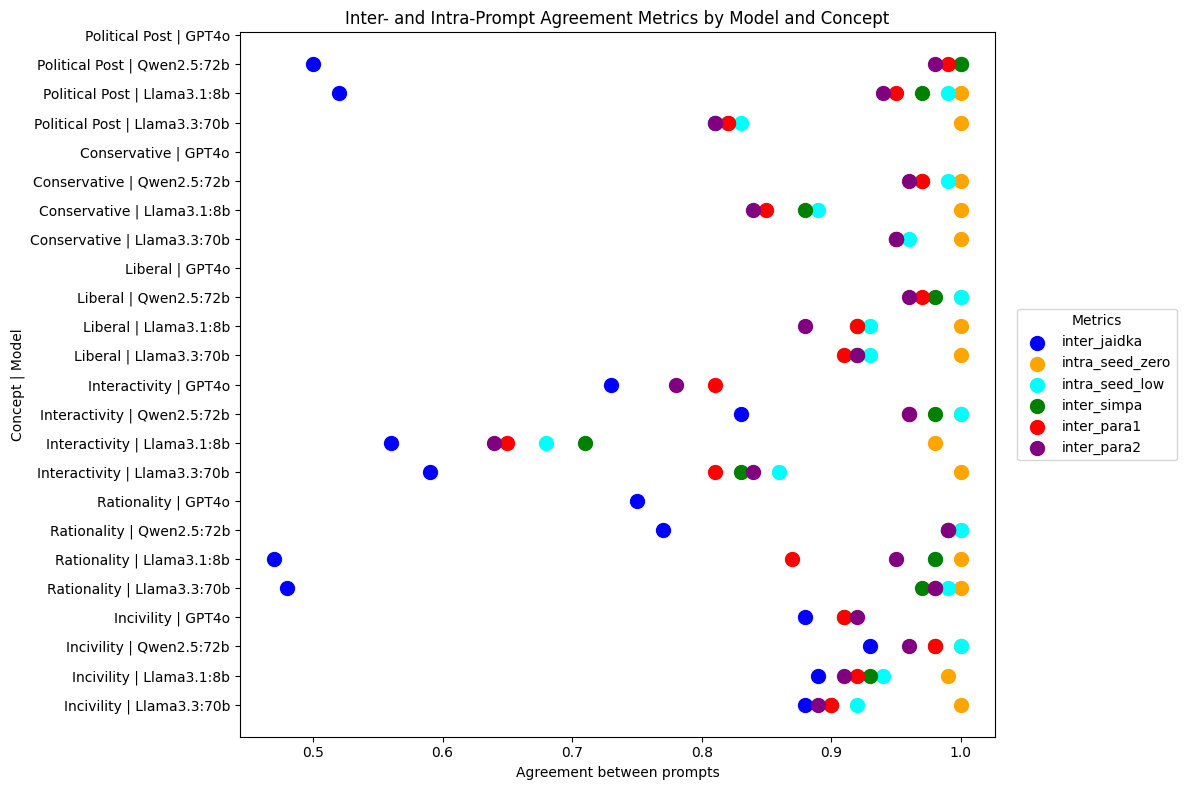

In [183]:
#visualize the results with dots per model and concept per row with different colors of each metric:
import matplotlib.pyplot as plt
# Set up the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Define colors for each metric
colors = {
    'inter_jaidka': 'blue',
    'intra_seed_zero': 'orange',
    'intra_seed_low': 'cyan',
    'inter_simpa': 'green',
    'inter_para1': 'red',
    'inter_para2': 'purple'
}

# Prepare y-tick labels: each row gets a unique label
y_labels = [f"{row['concept']} | {row['model']}" for _, row in df.iterrows()]
y_pos = range(len(df))

# Plot each row: accuracy values on x-axis, each row on y-axis
for i, (_, row) in enumerate(df.iterrows()):
    for metric, color in colors.items():
        if pd.notna(row[metric]):
            ax.scatter(row[metric], i, color=color, s=100, label=metric if i == 0 else "")

# Set y-ticks and labels
ax.set_yticks(y_pos)
ax.set_yticklabels(y_labels)
ax.set_xlabel('Agreement between prompts')
ax.set_ylabel('Concept | Model')
ax.set_title('Inter- and Intra-Prompt Agreement Metrics by Model and Concept')

# Set legend (unique labels only)
handles, labels_ = ax.get_legend_handles_labels()
unique = dict(zip(labels_, handles))
ax.legend(unique.values(), unique.keys(), title='Metrics', loc='center left', bbox_to_anchor=(1.02, 0.5))

plt.tight_layout()
plt.show()


We see that the differences between the annotations of different prompts vary strongly between concepts and models, with low variance for incivility, liberal and conservative, but higher variance for interactivity
and for political post and rationality, mainly strong difference between the jaidka and boukes prompts, but less so between

seed usually has the smallest effect followed by simpa, followed by para1 and para2
The intra-seed-low shows that temperature has a stronger effect interactivity for Llama-models and also explains the Lama models lower inter_simpa, inter_para1 and inter_para2

In [ ]:
#missing L33_70b: L33_70b_zero_run2; L33_70b_low_run2; L33_70b_zero_seed2_run2;
#missing L31_8b:  L31_8b_zero_seed2_run2; L31_8b_low_run2; 
#missing Q25_72b: Q25_72b_zero_run2; Q25_72b_low_run2; Q25_72b_zero_seed2_run2; Q25_72b_low_seed2_run2;


In [95]:
#load alternative boukes:
dataset_w_pred_2 = pd.read_json(f'{CFG.report_dir}/publicsphere.cardiff_prompt_classify_s.json')


In [105]:
dataset_w_pred_2.columns.sort_values().to_list()

['Acknowledgement',
 'All_caps_function',
 'Anonymity',
 'Anonymity_9_TEXT',
 'Attack_reputation',
 'BackgroundInfo',
 'CONSERVATIVE_DUMMY',
 'Coder',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Finished',
 'Genre',
 'HAS_OPINION_DUMMY',
 'HATELIST_FOCUSED_DUMMY',
 'ID',
 'IMPOLITENESS_DUMMY',
 'INCIVILITY_DUMMY',
 'INCIVILITY_ORDINAL',
 'INTERACTIVITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'IPAddress',
 'Ideologicaldirection',
 'Individual_right',
 'Interaction',
 'Invoke_violence',
 'LIBERAL_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'Mark_ID',
 'NAMECALLING_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'Name_calling',
 'Opinion',
 'Platform',
 'Question_Intelligenc',
 'RATIONALITY_DUMMY',
 'Reasoning',
 'RecordedDate',
 'Sarcasm_to_criticize',
 'StartDate',
 'Time_comment',
 'Time_comment_year',
 'Time_video',
 'Time_video_year',
 'Tone',
 'TopicRelevance',
 'VULGAR_DUMMY',
 'Vulgarity',
 'channelId',
 'channelTitle',
 'civility_jaidka_L31_8b',
 'civility_jaidka_L33_70b',
 'civility_jaidka_Q2

In [98]:
#load annotations:
predictions_intra_L8b = pd.read_parquet('data/publicsphere/predictions_intra_L8b.parquet')


In [99]:
predictions_intra_L8b

,incivility_simple2,interactivity_acknowledgement_simple,political_ideology_US,political_post,rationality_simple2
0,No,No,neutral,non-political,No
1,Yes,No,neutral,political,No
2,No,Yes,liberal,political,Yes
3,No,No,neutral,non-political,No
4,Yes,No,conservative,political,No
...,...,...,...,...,...
3127,Yes,No,neutral,non-political,No
3128,Yes,Yes,neutral,non-political,No
3129,No,Yes,neutral,non-political,Yes
3130,No,No,neutral,political,No


In [100]:
dataset_w_pred_2_YT = dataset_w_pred_2[dataset_w_pred_2['Platform'] == 1]

In [102]:
dataset_w_pred_2_YT.reset_index(inplace=True, drop=True)

In [110]:
boukesYT

,StartDate,RecordedDate,IPAddress,Finished,Coder,ID,Mark_ID,Genre,topiccode,Platform,...,interactivity_acknowledgement_para2_gpt4o_system_zero_dum,incivility_simpa1_gpt4o_system_zero_dum,political_ideology_US_gpt4o_zero_con_dum,political_ideology_US_gpt4o_zero_lib_dum,political_ideology_US_gpt4T_zero_con_dum,political_ideology_US_gpt4T_zero_lib_dum,political_ideology_US_gpt4o_system_zero_con_dum,political_ideology_US_gpt4o_system_zero_lib_dum,political_ideology_US_gpt4T_system_zero_con_dum,political_ideology_US_gpt4T_system_zero_lib_dum
0,5/30/2021 13:03:17,5/30/2021 13:04:17,62.194.51.29,1,6,UgyPHwv8G0cDE6-wEgl4AaABAg.8_0ZjJKSJty8_0kXGkAd2U,119,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,10/11/2021 10:34:05,10/11/2021 10:36:46,213.127.109.191,1,6,Ugx2WXq9UdV8mPPjejJ4AaABAg.8yHCKV0Boe58yYRxEQEF45,282,1,2,1,...,0,1,0,0,0,0,0,0,0,0
2,6/6/2021 16:12:46,6/6/2021 16:16:16,213.127.76.145,1,6,UgwUPFScjJ0MCeaP2F54AaABAg.8lvp3fc9Euf8lvvgsUgEgV,769,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,6/13/2021 13:25:49,6/13/2021 13:27:28,213.127.82.232,1,6,UgwWKCWtSJdFvjGHvTp4AaABAg.8kUC5dGrQ2H8kUDRihE2f3,1206,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,11/30/2021 17:24:18,11/30/2021 17:27:16,213.127.109.191,1,6,Ugw2eTvkZLfH9MDVg1R4AaABAg,1214,1,2,1,...,0,1,1,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3127,12/31/2021 15:07:40,12/31/2021 15:08:38,193.154.174.158,1,6,UgwiL6YZam5Xg4FWUHh4AaABAg,2002575,0,3,1,...,0,0,0,0,0,0,0,0,0,0
3128,10/19/2021 22:23:07,10/19/2021 22:24:30,213.127.109.191,1,6,UgxGubygP72yCR0-la14AaABAg,3000508,0,3,1,...,0,0,0,0,0,0,0,0,0,0
3129,10/6/2021 16:08:39,10/6/2021 16:10:42,213.127.113.113,1,6,UghFY3QJ6nmT_ngCoAEC.7-H0Z7--wxd8goqpaPs-bl,20000102,0,3,1,...,0,0,0,0,0,0,0,0,0,0
3130,10/15/2021 18:30:04,10/15/2021 18:35:40,213.127.109.191,1,6,UgyWabsmmnq3zam4DgZ4AaABAg,20000418,2,3,1,...,0,0,0,0,0,0,0,0,0,0


In [109]:
boukesYT= boukes[boukes['Platform'] == 1].reset_index(drop=True)

In [111]:
#join to the dataset:   
for _, preds in predictions_intra_L8b.items():
    print(preds.value_counts())
    print("-" * 42)
    boukesYT = boukesYT.join(preds, rsuffix='_L31_8b_low_seed2')

incivility_simple2
Yes    2050
No     1082
Name: count, dtype: int64
------------------------------------------
interactivity_acknowledgement_simple
No     2068
Yes    1064
Name: count, dtype: int64
------------------------------------------
political_ideology_US
neutral         1513
liberal          913
conservative     706
Name: count, dtype: int64
------------------------------------------
political_post
political        2111
non-political    1020
Name: count, dtype: int64
------------------------------------------
rationality_simple2
No     2609
Yes     523
Name: count, dtype: int64
------------------------------------------


In [119]:
boukes.columns.sort_values().to_list()

['Acknowledgement',
 'All_caps_function',
 'Anonymity',
 'Anonymity_9_TEXT',
 'Attack_reputation',
 'BackgroundInfo',
 'CONSERVATIVE_DUMMY',
 'Coder',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Finished',
 'Genre',
 'HAS_OPINION_DUMMY',
 'HATELIST_FOCUSED_DUMMY',
 'ID',
 'IMPOLITENESS_DUMMY',
 'INCIVILITY_DUMMY',
 'INCIVILITY_ORDINAL',
 'INTERACTIVITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'IPAddress',
 'Ideologicaldirection',
 'Individual_right',
 'Interaction',
 'Invoke_violence',
 'LIBERAL_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'Mark_ID',
 'NAMECALLING_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'Name_calling',
 'Opinion',
 'Platform',
 'Question_Intelligenc',
 'RATIONALITY_DUMMY',
 'Reasoning',
 'RecordedDate',
 'Sarcasm_to_criticize',
 'StartDate',
 'Time_comment',
 'Time_comment_year',
 'Time_video',
 'Time_video_year',
 'Tone',
 'TopicRelevance',
 'VULGAR_DUMMY',
 'Vulgarity',
 'cardiff_incivil',
 'channelId',
 'channelTitle',
 'civility_jaidka_L31_8b_low',
 'civility_jaidka_L31_8b

In [131]:
pd.merge(
    boukes,
    boukesYT.loc[:, [
        'Mark_ID',
        'incivility_simple2_L31_8b_low_seed2',
        'interactivity_acknowledgement_simple_L31_8b_low_seed2',
        'political_ideology_US_L31_8b_low_seed2',
        'political_post_L31_8b_low_seed2',
        'rationality_simple2_L31_8b_low_seed2'
    ]],
    on='Mark_ID',
    how='left'
).loc[:, [
        'Mark_ID',
        'incivility_simple2_L31_8b_low_seed2',
        'interactivity_acknowledgement_simple_L31_8b_low_seed2',
        'political_ideology_US_L31_8b_low_seed2',
        'political_post_L31_8b_low_seed2',
        'rationality_simple2_L31_8b_low_seed2',   'incivility_simpa1_Q25_72b_zero',

    ]]

,Mark_ID,incivility_simple2_L31_8b_low_seed2,interactivity_acknowledgement_simple_L31_8b_low_seed2,political_ideology_US_L31_8b_low_seed2,political_post_L31_8b_low_seed2,rationality_simple2_L31_8b_low_seed2,incivility_simpa1_Q25_72b_zero
0,119,No,No,neutral,non-political,No,No
1,282,Yes,No,neutral,political,No,Yes
2,372,NaN,NaN,NaN,NaN,NaN,None
3,769,No,Yes,liberal,political,Yes,No
4,1206,No,No,neutral,non-political,No,No
...,...,...,...,...,...,...,...
3857,10000695,NaN,NaN,NaN,NaN,NaN,None
3858,10007008,NaN,NaN,NaN,NaN,NaN,None
3859,20000102,No,Yes,neutral,non-political,Yes,No
3860,20000418,No,No,neutral,political,No,Yes


In [132]:
boukes =pd.merge(
    boukes,
    boukesYT.loc[:, [
        'Mark_ID',
        'incivility_simple2_L31_8b_low_seed2',
        'interactivity_acknowledgement_simple_L31_8b_low_seed2',
        'political_ideology_US_L31_8b_low_seed2',
        'political_post_L31_8b_low_seed2',
        'rationality_simple2_L31_8b_low_seed2'
    ]],
    on='Mark_ID',
    how='left'
)

In [133]:
boukes.columns

Index(['StartDate', 'RecordedDate', 'IPAddress', 'Finished', 'Coder', 'ID',
       'Mark_ID', 'Genre', 'topiccode', 'Platform',
       ...
       'political_ideology_US_gpt4T_zero_lib_dum',
       'political_ideology_US_gpt4o_system_zero_con_dum',
       'political_ideology_US_gpt4o_system_zero_lib_dum',
       'political_ideology_US_gpt4T_system_zero_con_dum',
       'political_ideology_US_gpt4T_system_zero_lib_dum',
       'incivility_simple2_L31_8b_low_seed2',
       'interactivity_acknowledgement_simple_L31_8b_low_seed2',
       'political_ideology_US_L31_8b_low_seed2',
       'political_post_L31_8b_low_seed2',
       'rationality_simple2_L31_8b_low_seed2'],
      dtype='object', length=548)

In [134]:
#save boukes with predictions:
boukes.to_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet', index=False)

In [ ]:
#join to the dataset:   
for _, preds in predictions_intra_L8b.items():
    print(preds.value_counts())
    print("-" * 42)
    dataset_w_pred_2 = dataset_w_pred_2_YT.join(preds, rsuffix='_L31_8b_low_seed2')

In [104]:
#join to the dataset:   
for _, preds in predictions_intra_L8b.items():
    print(preds.value_counts())
    print("-" * 42)
    dataset_w_pred_2 = dataset_w_pred_2_YT.join(preds, rsuffix='_L31_8b_low_seed2')


incivility_simple2
Yes    2050
No     1082
Name: count, dtype: int64
------------------------------------------
interactivity_acknowledgement_simple
No     2068
Yes    1064
Name: count, dtype: int64
------------------------------------------
political_ideology_US
neutral         1513
liberal          913
conservative     706
Name: count, dtype: int64
------------------------------------------
political_post
political        2111
non-political    1020
Name: count, dtype: int64
------------------------------------------
rationality_simple2
No     2609
Yes     523
Name: count, dtype: int64
------------------------------------------


In [107]:
dataset_w_pred_2.columns.to_list()

['StartDate',
 'RecordedDate',
 'IPAddress',
 'Finished',
 'Coder',
 'ID',
 'Mark_ID',
 'Genre',
 'topiccode',
 'Platform',
 'Anonymity',
 'Anonymity_9_TEXT',
 'codable',
 'Interaction',
 'Acknowledgement',
 'TopicRelevance',
 'Reasoning',
 'BackgroundInfo',
 'ExternalEvidence',
 'ExternalEvidence_1_TEXT',
 'Opinion',
 'disagreement',
 'Ideologicaldirection',
 'Name_calling',
 'Vulgarity',
 'Attack_reputation',
 'Question_Intelligenc',
 'All_caps_function',
 'Sarcasm_to_criticize',
 'Individual_right',
 'discrimination',
 'Invoke_violence',
 'Tone',
 'INTERACTIVITY_DUMMY',
 'RATIONALITY_DUMMY',
 'HAS_OPINION_DUMMY',
 'LIBERAL_NEUTRAL_CONSERVATIVE',
 'LIBERAL_DUMMY',
 'CONSERVATIVE_DUMMY',
 'NAMECALLING_DUMMY',
 'VULGAR_DUMMY',
 'NAMECALLING_VULGAR_DUMMY',
 'INCIVILITY_ORDINAL',
 'INCIVILITY_DUMMY',
 'INTOLERANCE_DUMMY',
 'filter_$',
 'IMPOLITENESS_DUMMY',
 'showName',
 'genre',
 'Time_comment',
 'likeCount_comment',
 'entities',
 'place',
 'retweet_count',
 'platform',
 'retweeted',
 '

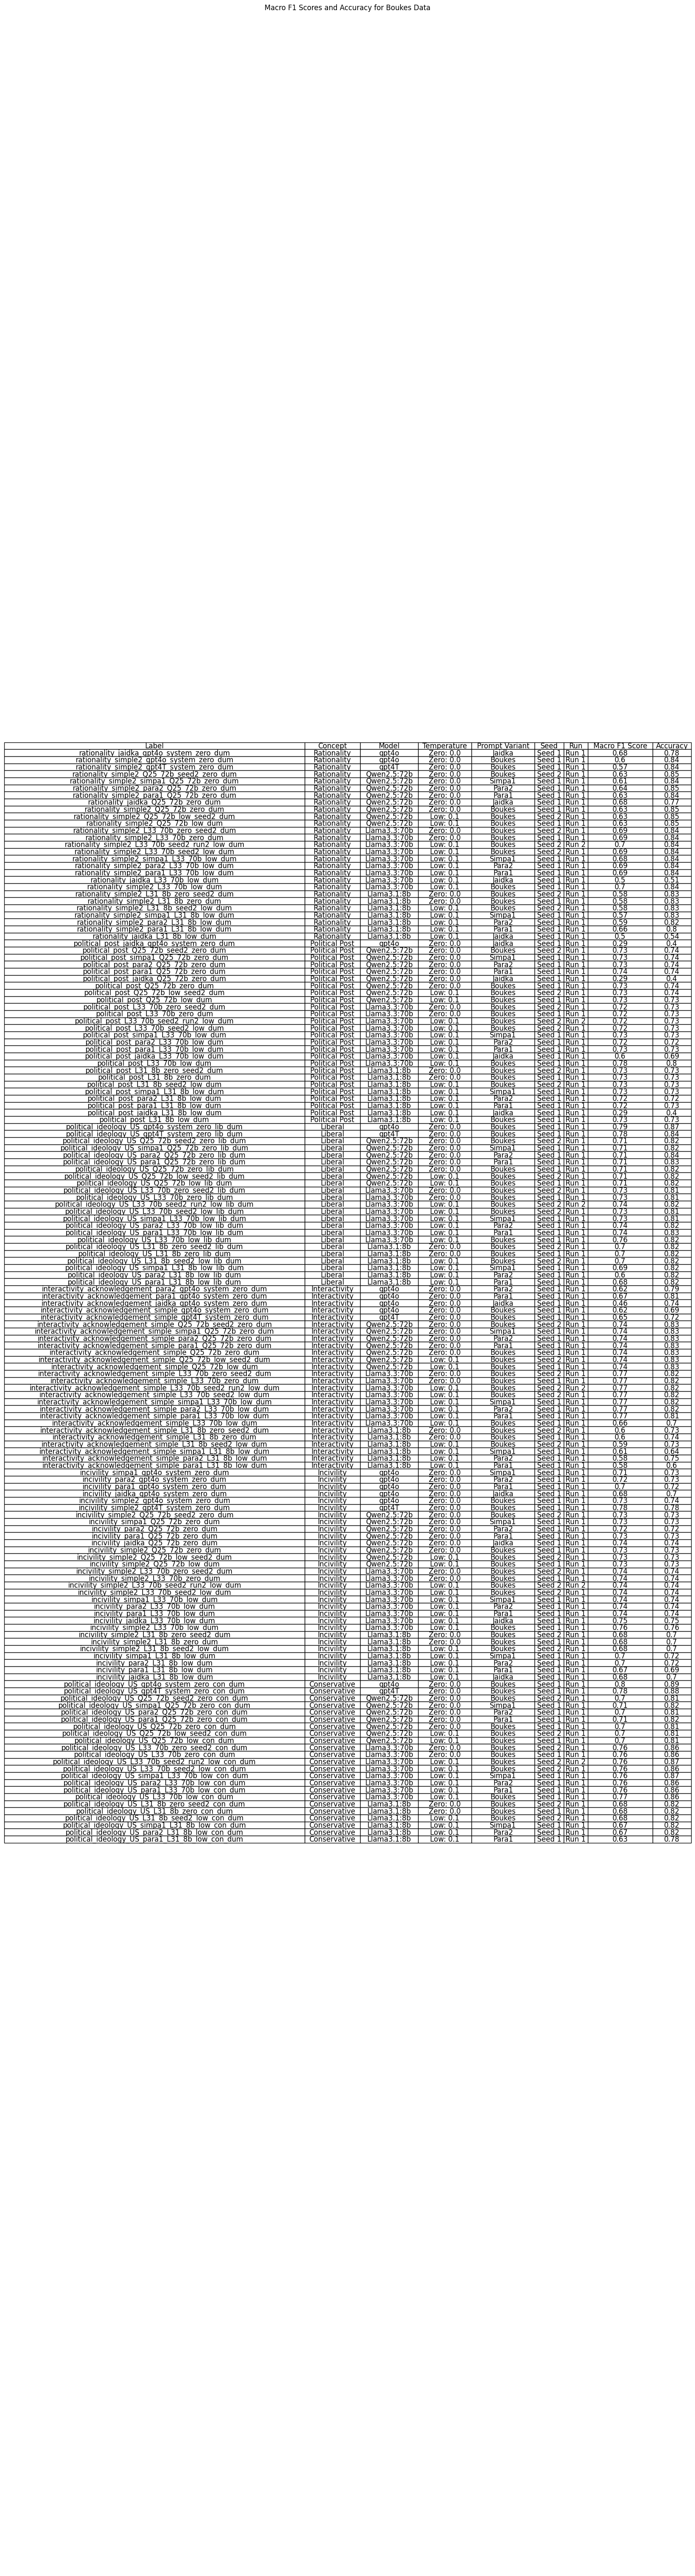

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, len(scores_df)*0.5 + 1))
ax.axis('off')
table = ax.table(
    cellText=scores_df.values,
    colLabels=scores_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(scores_df.columns))))
plt.title("Macro F1 Scores and Accuracy for Boukes Data")
plt.show()